### Настройка среды

In [2]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [4]:
%pip install belashovplot
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.modulators import Lens, PhaseModulator
from elements.propagators import FurrierPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors
from tqdm import tqdm
from math import sin, sqrt
import torch

### Цель эксперемента

Целью данного эксперемента является задание системы ...

### Настройка некогерентности

In [7]:
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 100

print(f"Временная когерентность:        {engineering(time_coherence, 'с')}")
print(f"Время релаксации:               {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность: {engineering(spatial_coherence, 'м')}")

Временная когерентность:        10.0 нс
Время релаксации:               1.0 мкc
Пространственная когерентность: 50.0 мкм


## Система без линз

Описание системы

### Настройка параметров системы

In [8]:
length = 10.0E-3
wavelength = 500E-9
mask_unit_length = 20.0E-6
masks_amount = 5
cppp = 3

pixels = int(length/mask_unit_length) + 1
N = int(pixels*cppp)
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.5

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Количество модуляторов:                   {masks_amount}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(mask_unit_length, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       1500
Количество пикселей маски:                500
Количество модуляторов:                   5
Размер оптических элементов:              10.0 мм
Размер пикселя маски:                     20.0 мкм
Расстояние между слоями:                  199.937 мм


### Отрисовка некогерентности

0.012639565393328667 0.48211465664062503
0.0007240549894049764 0.2975162139490659
0.0001432416756870225 0.36719853397266594
0.00010157173528568819 0.0002212897439064659
0.00010847953672055155 3.413984924849845e-05
9.340526594314724e-05 4.2135863547398474e-05
0.00010386995563749224 5.200465250921022e-05
0.00010224735888186842 2.0057764150554324e-06
9.863253217190504e-05 2.475556371564323e-06
0.0001704318419797346 1.5276825728911937e-06
9.819981642067432e-05 1.1784290545364871e-07
0.00010789744555950165 1.4544330726481788e-07
9.650282299844548e-05 1.7950809636519577e-07
9.247368871001527e-05 5.538782991572389e-08
9.708244033390656e-05 6.836040858083472e-08
0.0001018171024043113 5.21548527380636e-13
Parameter containing:
tensor([0.1342, 0.4326, 1.0085, 1.0105], device='cuda:0')
Out of Memory Error, split:2
Out of Memory Error, split:4
Out of Memory Error, split:8
Out of Memory Error, split:16
Out of Memory Error, split:32
Out of Memory Error, split:64
Out of Memory Error, resizing
Out of 

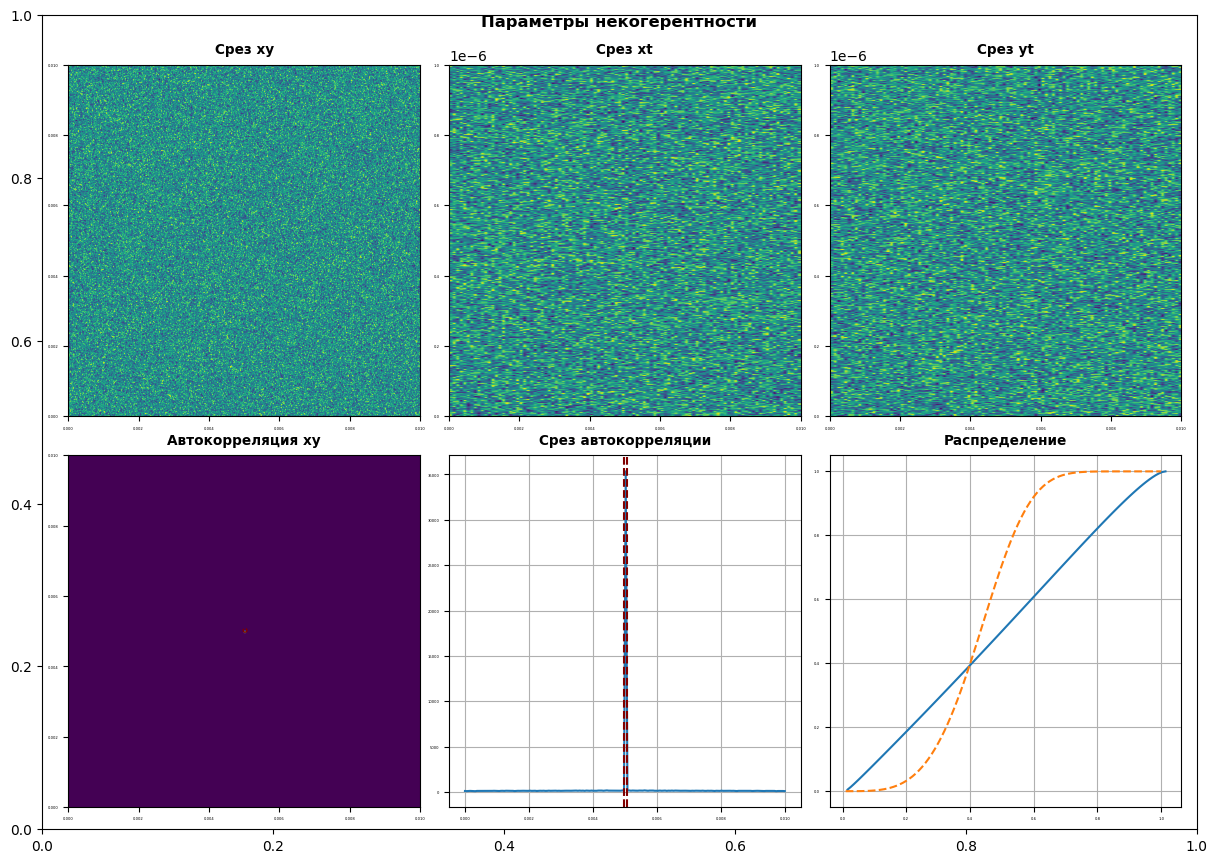

In [9]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent = incoherent.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
incoherent.delayed.launch()
incoherent.show()

### Инициализация оптической модели

In [10]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.7)
modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
elements = [modulators[0]]
for modulator in modulators[1:]:
    elements.append(propagation)
    elements.append(modulator)
elements.append(propagation)

chunker = CudaMemoryChunker()

optical = CompositeModel(*elements)
optical.wrap(chunker)
optical.wrap(incoherent)
optical.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

CompositeModel(
  (Element0): PhaseModulator()
  (Element1): FurrierPropagation()
  (Element2): PhaseModulator()
  (Element3): FurrierPropagation()
  (Element4): PhaseModulator()
  (Element5): FurrierPropagation()
  (Element6): PhaseModulator()
  (Element7): FurrierPropagation()
  (Element8): PhaseModulator()
  (Element9): FurrierPropagation()
)

### Инициализация детекторов

In [11]:
detectors_amount = 30

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/30, length/30), (0,0))
detectors = ClassificationDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter)
detectors.to(optical.device)

ClassificationDetectors()

### Инициализация электронной модели

In [12]:
layers_structure = [detectors_amount, detectors_amount, 15, 10]

layers = []
for nodes0, nodes1 in zip(layers_structure[:-1], layers_structure[1:]):
    layers.append(torch.nn.Linear(nodes0, nodes1))
    layers.append(torch.nn.Sigmoid())
electronic = torch.nn.Sequential(*layers)
electronic.to(optical.device)

Sequential(
  (0): Linear(in_features=30, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=15, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=15, out_features=10, bias=True)
  (5): Sigmoid()
)

### Инициализация гибридной модели

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

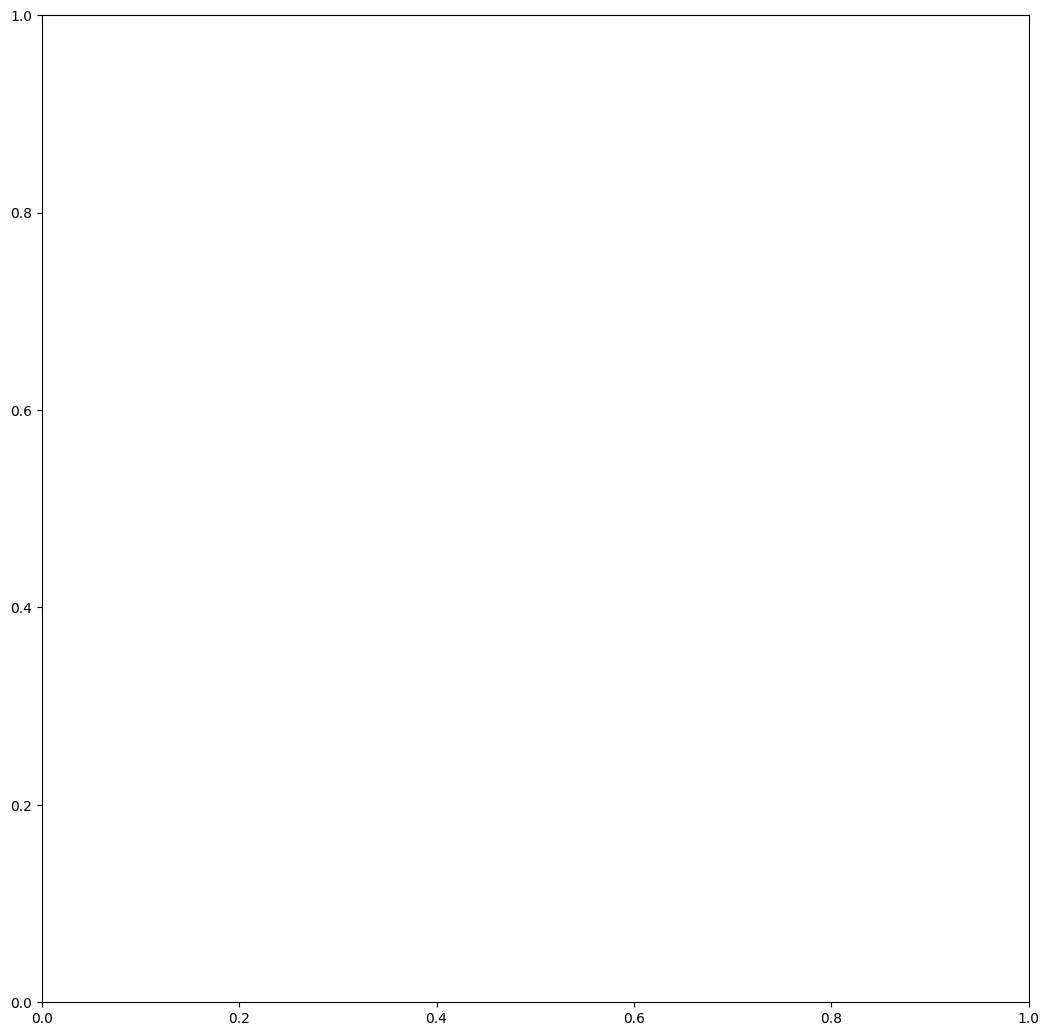

In [15]:
model = HybridModel(optical, detectors, electronic)
image, _ = Dataset.single('STL10', N, N, torch.complex64)
image = image.to(optical.device)
model.visualize(image)

### Инициализация набора данных

In [ ]:
dataset = Dataset('STL10', 100, N, N, torch.complex64)
dataset.train
dataset.test